## Import Libraries

In [1]:
import PIL
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import os
import glob
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Data directory containing images

In [3]:
data_dir = pathlib.Path('/content/drive/MyDrive/Project_Credible_Elections/PartySymbolDataset')

## Data Augmentation

Run this cell by uncommenting only when you want to augment images to the original dataset.

In [4]:
'''
ext = 'jpg' # specify the extension for the augmented images
prefix = 'aug' #set the prefix for the augmented images
batch_size = 32 # set the batch size
passes = 10  # set the number of time to cycle the generator
datagen = ImageDataGenerator( rotation_range = 60,
                                horizontal_flip = True, fill_mode = 'nearest', vertical_flip=True)
                                
data = datagen.flow_from_directory(
    directory = data_dir, batch_size = batch_size,  target_size = (180, 180),
    shuffle=True
)

for i in range (passes):
    
    images, labels = next(data)
    class_dict = data.class_indices
    new_dict = {}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value] = key    

    for j in range (len(labels)):                
        class_name = new_dict[np.argmax(labels[j])]         
        dir_path = os.path.join(data_dir,class_name)         
        new_file = prefix + '-' + str(i*batch_size +j) + '.'  + ext       
        img_path = os.path.join(dir_path, new_file)
        img = cv2.cvtColor(images[j], cv2.COLOR_BGR2RGB)
        cv2.imwrite(img_path, img)
'''

"\next = 'jpg' # specify the extension for the augmented images\nprefix = 'aug' #set the prefix for the augmented images\nbatch_size = 32 # set the batch size\npasses = 10  # set the number of time to cycle the generator\ndatagen = ImageDataGenerator( rotation_range = 60,\n                                horizontal_flip = True, fill_mode = 'nearest', vertical_flip=True)\n                                \ndata = datagen.flow_from_directory(\n    directory = data_dir, batch_size = batch_size,  target_size = (180, 180),\n    shuffle=True\n)\n\nfor i in range (passes):\n    \n    images, labels = next(data)\n    class_dict = data.class_indices\n    new_dict = {}\n    # make a new dictionary with keys and values reversed\n    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}\n        new_dict[value] = key    \n\n    for j in range (len(labels)):                \n        class_name = new_dict[np.argmax(labels[j])]         \n        dir_path

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Total number of images in the dataset: ",image_count)

Total number of images in the dataset:  895


### Define batch size and image dimensions

In [6]:
batch_size = 32
img_height = 180
img_width = 180
EPOCHS = 15

### Train and Validation split (80-20)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% validation set
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 895 files belonging to 49 classes.
Using 716 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 895 files belonging to 49 classes.
Using 179 files for validation.


### Class - Parties contested in Telungana State elections.

In [9]:
class_names = train_ds.class_names
print(class_names)

['Aam Aadmi Party', 'All India Anna Dravida Munnetra', 'All India Forward Bloc', 'All India Majlis-E-Ittehadul Muslimeen', 'All India NR Congress', 'All India United Democratic Front', 'All Jharkand Students Union', 'Bahujan Samaj Party', 'Bharatiya Janata Party', 'Biju Janata Dal', 'Bodoland Peoples Front', 'Communist Party of India', 'Communist Party of India Liberation Marxist', 'Communist Party of India Marxist', 'Desiya Murpokku Dravida Kazhagam', 'Dravida Munnetra Kazhagam', 'Goa Forward Party', 'Indian National Congress', 'Indian National Lok Dal', 'Indian Union Muslim League', 'Indigenous People Front of Tripura', 'Jammu Kashmir National Conference', 'Jammu Kashmir Peoples Democratic', 'Janata Congress Chattisgarh', 'Janata Dal Secular', 'Janata Dal United', 'Jannayak Janta Party', 'Lok Jansakthi Party', 'Maharashtra Navnirman Sena', 'Mizoram National Front', 'Mizoram Peoples Conference', 'Naga Peoples Front', 'Nationalist Congress Party', 'Nationalist Democratic Progressive Pa

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer Learning

## Using following pretrained models :



*   MobileNet v2
*   ResNet50



### MobileNet v2

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # Load preprocessing steps for MobileNet V2

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) ## Rescaling pixel values

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (180,180,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [18]:
num_classes = len(class_names)

In [19]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 49)


### Wrapping MobileNet v2

In [20]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [23]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/15
23/23 [==============================] - 23s 879ms/step - loss: 4.4856 - accuracy: 0.0307 - val_loss: 3.8229 - val_accuracy: 0.0615
Epoch 2/15
23/23 [==============================] - 18s 802ms/step - loss: 3.7934 - accuracy: 0.0559 - val_loss: 3.3346 - val_accuracy: 0.1229
Epoch 3/15
23/23 [==============================] - 21s 922ms/step - loss: 3.2490 - accuracy: 0.1341 - val_loss: 2.9144 - val_accuracy: 0.2793
Epoch 4/15
23/23 [==============================] - 19s 820ms/step - loss: 2.7799 - accuracy: 0.2500 - val_loss: 2.5407 - val_accuracy: 0.4637
Epoch 5/15
23/23 [==============================] - 18s 809ms/step - loss: 2.3949 - accuracy: 0.4106 - val_loss: 2.2015 - val_accuracy: 0.6257
Epoch 6/15
23/23 [==============================] - 19s 824ms/step - loss: 2.0468 - accuracy: 0.5419 - val_loss: 1.9105 - val_accuracy: 0.7095
Epoch 7/15
23/23 [==============================] - 19s 820ms/step - loss: 1.7078 - accuracy: 0.6830 - val_loss: 1.6482 - val_accuracy: 0.8324

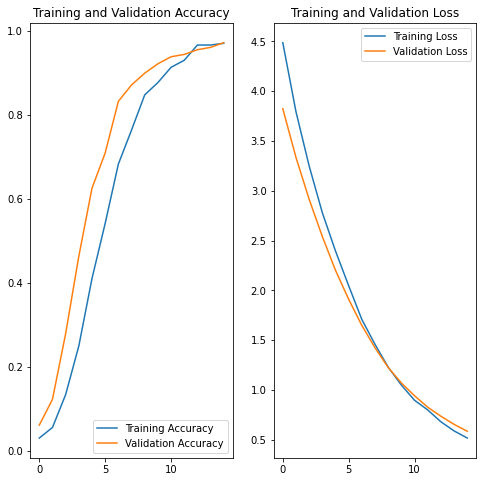

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = EPOCHS
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save and load model

In [26]:
model.save('/content/drive/MyDrive/Project_Credible_Elections/mobilenetv2_party_classifier.hdf5')

In [27]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Project_Credible_Elections/mobilenetv2_party_classifier.hdf5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

## ResNet50 model

In [28]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input # Load preprocessing steps for ResNet50

In [29]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # Rescale input pixels

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (180,180,3)
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [31]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [32]:
base_model.trainable = False # Freeze parameters of base model.
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [34]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape) # predictions

(32, 49)


### Wrapping ResNet50 model

In [35]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0   

In [37]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/15
23/23 [==============================] - 108s 5s/step - loss: 4.3283 - accuracy: 0.0349 - val_loss: 3.5966 - val_accuracy: 0.0447
Epoch 2/15
23/23 [==============================] - 99s 4s/step - loss: 3.5328 - accuracy: 0.1089 - val_loss: 3.0184 - val_accuracy: 0.1844
Epoch 3/15
23/23 [==============================] - 101s 4s/step - loss: 2.8999 - accuracy: 0.2793 - val_loss: 2.5278 - val_accuracy: 0.3855
Epoch 4/15
23/23 [==============================] - 100s 4s/step - loss: 2.3538 - accuracy: 0.4232 - val_loss: 2.1058 - val_accuracy: 0.6145
Epoch 5/15
23/23 [==============================] - 100s 4s/step - loss: 1.9584 - accuracy: 0.5433 - val_loss: 1.7474 - val_accuracy: 0.7598
Epoch 6/15
23/23 [==============================] - 101s 4s/step - loss: 1.5624 - accuracy: 0.7095 - val_loss: 1.4524 - val_accuracy: 0.8603
Epoch 7/15
23/23 [==============================] - 101s 4s/step - loss: 1.2880 - accuracy: 0.8031 - val_loss: 1.2069 - val_accuracy: 0.9274
Epoch 8/15
23/

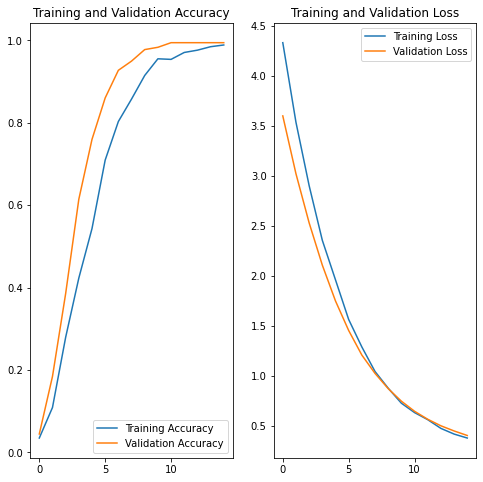

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = EPOCHS
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model.save('/content/drive/MyDrive/Project_Credible_Elections/resnet50_party_classifier.hdf5')

In [40]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Project_Credible_Elections/resnet50_party_classifier.hdf5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0   

## Prediction on Test image

In [ ]:
'''
image_path = ''
img = cv2.imread(image_path)
img = cv2.resize(img, (180, 180))
np.argmax(model.predict(np.expand_dims(img, 0)))
print("\nPrediction: ",class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])
'''

'\nimage_path = \'\'\nimg = cv2.imread(image_path)\nimg = cv2.resize(img, (180, 180))\nnp.argmax(model.predict(np.expand_dims(img, 0)))\nprint("\nPrediction: ",class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])\n'

In [ ]:
"""
dir = '/content/drive/MyDrive/Project_Credible_Elections'

train_ds = tf.keras.utils.image_dataset_from_directory(
  dir + '/trainset',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  dir + '/evalset',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

X_train = np.array([]).reshape((0,180,180,3))
y_train = np.array([],dtype=np.Uint64).reshape(0,)
for x, y in train_ds:
  X_train = np.concatenate((X_train, x), axis=0)
  y_train = np.concatenate((y_train, y),axis=0)

X_test = np.array([]).reshape((0,180,180,3))
y_test = np.array([],dtype=np.Uint64).reshape(0,)
for x, y in test_ds:
  X_test = np.concatenate((X_test, x), axis=0)
  y_test = np.concatenate((y_test, y), axis=0)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# We have 2 inputs, 1 for each picture
left_input = Input((img_height,img_width,3))
right_input = Input((img_height,img_width,3))

# We will use 2 instances of 1 network for this task
convnet = Sequential([
    Conv2D(5,3, input_shape=(img_height,img_width,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.001, decay=2.5e-4)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

image_list = np.split(X_train[:16],16)
label_list = np.split(y_train[:16],16)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,15)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

image = X_train[10]
test_left = []
test_right = []
test_targets = []

for i in range(y_train.shape[0]-16):
    test_left.append(image)
    test_right.append(X_train[i+16])
    test_targets.append(y_train[i+16])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

siamese_net.summary()
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))
"""

'\ndir = \'/content/drive/MyDrive/Project_Credible_Elections\'\n\ntrain_ds = tf.keras.utils.image_dataset_from_directory(\n  dir + \'/trainset\',\n  seed=123,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\n\ntest_ds = tf.keras.utils.image_dataset_from_directory(\n  dir + \'/evalset\',\n  seed=123,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\n\nX_train = np.array([]).reshape((0,180,180,3))\ny_train = np.array([],dtype=np.Uint64).reshape(0,)\nfor x, y in train_ds:\n  X_train = np.concatenate((X_train, x), axis=0)\n  y_train = np.concatenate((y_train, y),axis=0)\n\nX_test = np.array([]).reshape((0,180,180,3))\ny_test = np.array([],dtype=np.Uint64).reshape(0,)\nfor x, y in test_ds:\n  X_test = np.concatenate((X_test, x), axis=0)\n  y_test = np.concatenate((y_test, y), axis=0)\n\nX_train = X_train.astype(\'float32\')\nX_test = X_test.astype(\'float32\')\nX_train /= 255\nX_test /= 255\n\n# We have 2 inputs, 1 for each picture\nleft_input = Input((img_h